In [172]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [173]:
ls

IMU_Streams/  Radar_Data/                  SensorConfig.docx
plot.png      Radar_PostProcess_Heatmaps/




---


Change Dir to Shared Drive that Contains RADAR Heatmap Images

In [174]:
import os
os.chdir("/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/Data/")

In [175]:
ls

IMU_Streams/  Radar_Data/                  SensorConfig.docx
plot.png      Radar_PostProcess_Heatmaps/




---
Install PyTorch and Ensure GPU is Working


In [176]:
!pip3 install torch torchvision

In [177]:
import glob
import cv2
import os
import os.path as osp
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets

torch.cuda.empty_cache()

In [178]:
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [179]:
torch.cuda.is_available()

True



---


Radar Heatmaps Custom Dataset

In [180]:
class_map = {
    'bicyclerack': 0,
    'bush': 1,
    'firehydrant': 2,
    'human': 3,
    'lamppost': 4,
    'middle_of_sidewalk': 5,
    'tree': 6,
    'wall': 7
}


class CustomDataset(Dataset):

    def __init__(self, fold='train', transform=None, target_transform=None):
        self.imgs_path = 'Radar_PostProcess_Heatmaps/'
        file_list = glob.glob(self.imgs_path + '*')
        print(file_list)

        self.data = []
        for class_path in file_list:
            class_name = class_path.split('/')[-1]
            # a class can have multiple scenarios (wall class -> glass wall, brick wall)
            for scenario_dir in glob.glob(class_path + '/' + '*'):
                scenario_dir_heatmaps_regex = 'allobjects_1m_*_noaxis.png'
                for img_path in glob.glob(scenario_dir + '/' + scenario_dir_heatmaps_regex):
                    if fold == 'train':
                        if self.is_val_img(img_path):
                            continue
                        self.data.append([img_path, class_name])
                    else:
                        if self.is_val_img(img_path):
                            self.data.append([img_path, class_name])
        print(self.data)
        
        self.class_map = class_map
        self.img_dim = (400, 200)
        self.transform = transform
        self.target_transform = target_transform
    
    
    def __len__(self):
        return len(self.data)

    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        target = self.class_map[class_name]
        #img_tensor = torch.from_numpy(img)
        #img_tensor = img_tensor.permute(2, 0, 1)
        # target = torch.tensor([target])
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    
    def is_val_img(self, img_path):
        # To divide heatmaps in same folder into train and test sets
        val_frames = ['_frame4_', '_frame12_', '_frame14_', '_frame15_', '_frame21_', 
                      '_frame24_', '_frame29_', '_frame31_', '_frame35_', '_frame44_',
                      '_frame50_', '_frame54_', '_frame55_', '_frame57_', '_frame60_', 
                      '_frame62_', '_frame73_', '_frame85_', '_frame90_', '_frame93_']
        for frame_num in val_frames:
            if frame_num in img_path:
              return True
        return False



---


Custom Dataloader

In [181]:
train_set = CustomDataset(fold='train', transform=None)		
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
print(f'Train Set Size: {len(train_set)}')

val_set = CustomDataset(fold='val', transform=None)		
val_dataloader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
print(f'Val Set Size: {len(val_set)}')

['Radar_PostProcess_Heatmaps/bicyclerack', 'Radar_PostProcess_Heatmaps/bush', 'Radar_PostProcess_Heatmaps/firehydrant', 'Radar_PostProcess_Heatmaps/human', 'Radar_PostProcess_Heatmaps/lamppost', 'Radar_PostProcess_Heatmaps/middle_of_sidewalk', 'Radar_PostProcess_Heatmaps/tree', 'Radar_PostProcess_Heatmaps/wall']
[['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame0_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame1_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame2_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame3_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame5_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame6_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bi

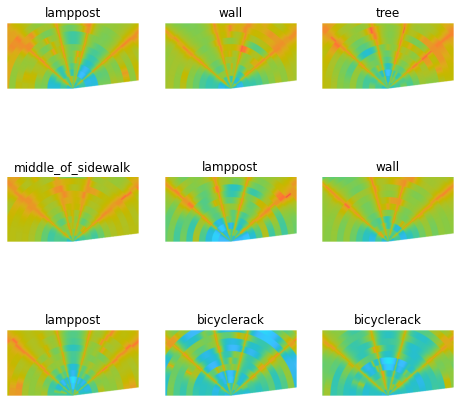

In [182]:
labels_map = dict((v,k) for k,v in class_map.items())

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

Feature batch shape: torch.Size([32, 200, 400, 3])
Labels batch shape: torch.Size([32])


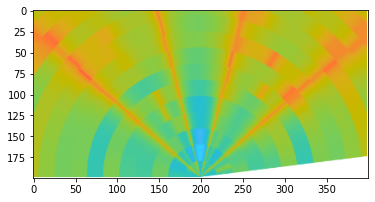

Label: 7
Class: wall


In [183]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")
print(f"Class: {labels_map[label.item()]}")



---


#Training from Scratch with Custom CNN Model (Baseline)

In [184]:
EPOCHS = 10
IS_GPU = True
TRAIN_BS = 32
VAL_BS = 4
TOTAL_CLASSES = 8

train_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize([0,0,0], [1,1,1]), 
     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
     transforms.RandomHorizontalFlip()])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0,0,0], [1,1,1])
     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
     ])

train_set = CustomDataset(fold='train', transform=train_transform)		
train_dataloader = DataLoader(train_set, batch_size=TRAIN_BS, shuffle=True, num_workers=2)
print(f'Train Set Size: {len(train_set)}')

val_set = CustomDataset(fold='val', transform=val_transform)		
val_dataloader = DataLoader(train_set, batch_size=VAL_BS, shuffle=True, num_workers=2)
print(f'Val Set Size: {len(val_set)}')

['Radar_PostProcess_Heatmaps/bicyclerack', 'Radar_PostProcess_Heatmaps/bush', 'Radar_PostProcess_Heatmaps/firehydrant', 'Radar_PostProcess_Heatmaps/human', 'Radar_PostProcess_Heatmaps/lamppost', 'Radar_PostProcess_Heatmaps/middle_of_sidewalk', 'Radar_PostProcess_Heatmaps/tree', 'Radar_PostProcess_Heatmaps/wall']
[['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame0_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame1_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame2_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame3_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame5_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame6_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bi

In [185]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        # <<TODO#3>> Add more conv layers with increasing 
        # output channels
        # <<TODO#4>> Add normalization layers after conv
        # layers (nn.BatchNorm2d)

        # Also experiment with kernel size in conv2d layers (say 3
        # inspired from VGGNet)
        # To keep it simple, keep the same kernel size
        # (right now set to 5) in all conv layers.
        # Do not have a maxpool layer after every conv layer in your
        # deeper network as it leads to too much loss of information.

        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 6, 3)

        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)

        # self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # self.norm1 = nn.BatchNorm2d(16)

        # self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # self.norm2 = nn.BatchNorm2d(32)

        # self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # self.norm3 = nn.BatchNorm2d(64)

        # self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # self.norm4 = nn.BatchNorm2d(128)

        # self.pool = nn.MaxPool2d(2, 2)

        # <<TODO#3>> Add more linear (fc) layers
        # <<TODO#4>> Add normalization layers after linear and
        # experiment inserting them before or after ReLU (nn.BatchNorm1d)
        # More on nn.sequential:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Sequential
        
        self.fc_net = nn.Sequential(
            nn.Linear(114654, TOTAL_CLASSES//2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(TOTAL_CLASSES//2),
            nn.Linear(TOTAL_CLASSES//2, TOTAL_CLASSES),
        )

        # self.fc_net = nn.Sequential(
        #     nn.Linear(256 * 8 * 8, 2048),
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm1d(2048),
        #     nn.Linear(2048, 512),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(512, TOTAL_CLASSES),
        # )

    def forward(self, x):

        # <<TODO#3&#4>> Based on the above edits, you'll have
        # to edit the forward pass description here.

        # x = self.pool(F.relu(self.conv1(x)))
        # Output size = 28//2 x 28//2 = 14 x 14

        # x = self.pool(F.relu(self.conv2(x)))
        # Output size = 10//2 x 10//2 = 5 x 5

        x = self.norm1(F.relu(self.conv1(x)))
        x = self.norm2(F.relu(self.conv2(x)))
        x = self.pool(self.norm1(F.relu(self.conv3(x))))

        # See the CS231 link to understand why this is 16*5*5!
        # This will help you design your own deeper network
        x = x.view(x.size(0), 114654)
        x = self.fc_net(x)

        # x = F.relu(self.norm1(self.conv1(x)))
        # x = F.relu(self.norm2(self.conv2(x)))
        # x = self.pool(F.relu(self.norm3(self.conv3(x))))
        # x = self.pool(F.relu(self.norm4(self.conv4(x))))

        # x = x.view(x.size(0), 640000)
        # x = self.fc_net(x)

        # No softmax is needed as the loss function in step 3
        # takes care of that
        
        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()
    model_total_params = sum(p.numel() for p in net.parameters())
    print(f'Total Params: {model_total_params}')


Total Params: 460630


In [186]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum is useful or not
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []


<Figure size 432x288 with 0 Axes>

In [187]:
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    for data in valloader:
        images, labels = data
        if is_gpu:
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(list(predicted.cpu().numpy()))
        total += labels.size(0)
        correct += (predicted == labels).sum()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy

[1] loss: 1.844
Accuracy of the network on the val images: 35 %
Accuracy of bicyclerack :  2 %
Accuracy of  bush :  0 %
Accuracy of firehydrant : 39 %
Accuracy of human :  0 %
Accuracy of lamppost : 50 %
Accuracy of middle_of_sidewalk : 73 %
Accuracy of  tree :  2 %
Accuracy of  wall : 34 %
[2] loss: 1.525
Accuracy of the network on the val images: 36 %
Accuracy of bicyclerack :  0 %
Accuracy of  bush : 20 %
Accuracy of firehydrant : 26 %
Accuracy of human :  0 %
Accuracy of lamppost : 58 %
Accuracy of middle_of_sidewalk : 71 %
Accuracy of  tree :  0 %
Accuracy of  wall : 39 %
[3] loss: 1.386
Accuracy of the network on the val images: 41 %
Accuracy of bicyclerack :  5 %
Accuracy of  bush : 38 %
Accuracy of firehydrant : 28 %
Accuracy of human :  0 %
Accuracy of lamppost : 59 %
Accuracy of middle_of_sidewalk : 75 %
Accuracy of  tree :  5 %
Accuracy of  wall : 44 %
[4] loss: 1.268
Accuracy of the network on the val images: 46 %
Accuracy of bicyclerack : 21 %
Accuracy of  bush : 46 %
Accu

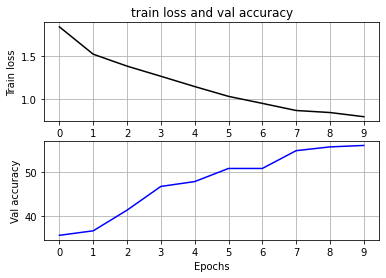

In [188]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0.
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        total += labels.size(0)

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss/=len(train_dataloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_val_accuracy(val_dataloader, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # Optionally print classwise accuracies
    for c_i in range(TOTAL_CLASSES):
        print('Accuracy of %5s : %2d %%' % (
            labels_map[c_i], val_classwise_accuracy[c_i]))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy)
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("plot.png")
plt.close(fig)
print('Finished Training')
# -------------

#Transfer Learning with Pretrained Models

In [189]:
class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()
    
    #TODO1: Load pre-trained ResNet Model
    self.resnet18 = models.resnet18(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.resnet18.parameters():
          param.requires_grad = False
    
    #Replace last fc layer
    num_feats = self.resnet18.fc.in_features
    
    #TODO2: Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
    self.resnet18.fc = nn.Linear(num_feats, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.resnet18(x)

    return x


class PreTrainedVGGNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedVGGNet, self).__init__()
    
    #TODO1: Load pre-trained VGGNet Model
    self.vgg11 = models.vgg11(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.vgg11.parameters():
          param.requires_grad = False
    
    #Replace output layer (Ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
    self.vgg11.classifier[6] = nn.Linear(4096, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.vgg11(x)

    return x


class PreTrainedSqueezeNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedSqueezeNet, self).__init__()
    
    #TODO1: Load pre-trained SqueezeNet Model
    self.squeezenet1_0 = models.squeezenet1_0(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.squeezenet1_0.parameters():
          param.requires_grad = False
    
    #TODO2: Replace output layer (Ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
    self.squeezenet1_0.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    self.squeezenet1_0.num_classes = num_classes
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.squeezenet1_0(x)

    return x


class PreTrainedMobileNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedMobileNet, self).__init__()
    
    #TODO1: Load pre-trained MobileNet Model
    self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.mobilenet_v2.parameters():
          param.requires_grad = False
    
    #TODO2: Replace output layer (Ref: https://stackoverflow.com/questions/57285224/fine-tuning-pretrained-model-mobilenet-v2-in-pytorch)
    self.mobilenet_v2.classifier[1] = nn.Linear(self.mobilenet_v2.last_channel, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.mobilenet_v2(x)

    return x




In [190]:
# Nothing to be edited in this cell
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    model.eval()
  
    correct = 0.0
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))
  
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(valloader):
          #move to GPU
          images, labels = images.cuda(), labels.cuda()
          total += labels.size(0)

          #forward
          outputs = model.forward(images)

          _, preds = torch.max(outputs.data, 1)
          predictions.extend(list(preds.cpu().numpy()))

          correct += (preds == labels).sum()

          c = (preds == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i]
              class_total[label] += 1

        
    class_accuracy = 100*np.divide(class_correct, class_total)
    validation_acc = 100*correct/total

    return validation_acc, class_accuracy


In [191]:
def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0
  total = 0.
  
  for batch_idx, (images, labels) in enumerate(train_dataloader):
    #zero the parameter gradients
    optimizer.zero_grad()
    
    #move to GPU
    images, labels = images.cuda(), labels.cuda()
    total += labels.size(0)
    
    #forward
    outputs = model.forward(images)
    
    loss = criterion(outputs, labels)
    
    _, preds = torch.max(outputs.data, 1)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()
    
  epoch_loss /= len(train_dataloader)
  epoch_acc /= total

  # Calculate validation set accuracy of the existing model
  val_accuracy, val_classwise_accuracy = \
      calculate_val_accuracy(val_dataloader, IS_GPU)
  
  print('Epoch %d/%d Training Loss %.4f Training Accuracy %d %% Validation Accuracy %d %%' % (epoch, num_epochs, epoch_loss, 100*epoch_acc, val_accuracy))

  # Optionally print classwise accuracies
  for c_i in range(TOTAL_CLASSES):
    print('Accuracy of %5s : %2d %%' % (labels_map[c_i], val_classwise_accuracy[c_i]))
  

In [192]:
#TODO: Vary Hyperparams

IS_GPU = True
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
TRAIN_BS = 32
VAL_BS = 4
TOTAL_CLASSES = 8

train_transform = transforms.Compose(
    [transforms.ToTensor(), 
     #transforms.Normalize([0,0,0], [1,1,1]), 
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
     transforms.RandomHorizontalFlip()])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize([0,0,0], [1,1,1])
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
     ])

train_set = CustomDataset(fold='train', transform=train_transform)		
train_dataloader = DataLoader(train_set, batch_size=TRAIN_BS, shuffle=True, num_workers=2)
print(f'Train Set Size: {len(train_set)}')

val_set = CustomDataset(fold='val', transform=val_transform)		
val_dataloader = DataLoader(train_set, batch_size=VAL_BS, shuffle=True, num_workers=2)
print(f'Val Set Size: {len(val_set)}')

['Radar_PostProcess_Heatmaps/bicyclerack', 'Radar_PostProcess_Heatmaps/bush', 'Radar_PostProcess_Heatmaps/firehydrant', 'Radar_PostProcess_Heatmaps/human', 'Radar_PostProcess_Heatmaps/lamppost', 'Radar_PostProcess_Heatmaps/middle_of_sidewalk', 'Radar_PostProcess_Heatmaps/tree', 'Radar_PostProcess_Heatmaps/wall']
[['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame0_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame1_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame2_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame3_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame5_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bicyclerack/adc_data_rack_hub/allobjects_1m_frame6_noaxis.png', 'bicyclerack'], ['Radar_PostProcess_Heatmaps/bi

##ResNet18

In [193]:
RESNET_LAST_ONLY = False #Fine tunes only the last layer. Set to False to fine tune entire network

#Initialize the model
model = PreTrainedResNet(TOTAL_CLASSES, RESNET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

Total Params: 11180616
Epoch 1/10 Training Loss 1.4564 Training Accuracy 46 % Validation Accuracy 64 %
Accuracy of bicyclerack : 10 %
Accuracy of  bush : 59 %
Accuracy of firehydrant : 61 %
Accuracy of human : 51 %
Accuracy of lamppost : 52 %
Accuracy of middle_of_sidewalk : 85 %
Accuracy of  tree : 56 %
Accuracy of  wall : 82 %
Epoch 2/10 Training Loss 0.8637 Training Accuracy 70 % Validation Accuracy 78 %
Accuracy of bicyclerack : 80 %
Accuracy of  bush : 90 %
Accuracy of firehydrant : 65 %
Accuracy of human : 46 %
Accuracy of lamppost : 88 %
Accuracy of middle_of_sidewalk : 95 %
Accuracy of  tree : 46 %
Accuracy of  wall : 82 %
Epoch 3/10 Training Loss 0.6177 Training Accuracy 81 % Validation Accuracy 84 %
Accuracy of bicyclerack : 91 %
Accuracy of  bush : 75 %
Accuracy of firehydrant : 73 %
Accuracy of human : 45 %
Accuracy of lamppost : 96 %
Accuracy of middle_of_sidewalk : 94 %
Accuracy of  tree : 67 %
Accuracy of  wall : 92 %
Epoch 4/10 Training Loss 0.4538 Training Accuracy 86 

##VGGNet

In [194]:
VGGNET_LAST_ONLY = False

#Initialize the model
model = PreTrainedVGGNet(TOTAL_CLASSES, VGGNET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

Total Params: 128799112
Epoch 1/10 Training Loss 1.7014 Training Accuracy 33 % Validation Accuracy 45 %
Accuracy of bicyclerack : 70 %
Accuracy of  bush : 38 %
Accuracy of firehydrant : 10 %
Accuracy of human :  1 %
Accuracy of lamppost : 94 %
Accuracy of middle_of_sidewalk : 21 %
Accuracy of  tree : 19 %
Accuracy of  wall : 69 %
Epoch 2/10 Training Loss 1.1568 Training Accuracy 54 % Validation Accuracy 69 %
Accuracy of bicyclerack : 85 %
Accuracy of  bush : 77 %
Accuracy of firehydrant : 47 %
Accuracy of human : 15 %
Accuracy of lamppost : 89 %
Accuracy of middle_of_sidewalk : 92 %
Accuracy of  tree : 41 %
Accuracy of  wall : 67 %
Epoch 3/10 Training Loss 0.8744 Training Accuracy 66 % Validation Accuracy 76 %
Accuracy of bicyclerack : 85 %
Accuracy of  bush : 86 %
Accuracy of firehydrant : 79 %
Accuracy of human : 71 %
Accuracy of lamppost : 81 %
Accuracy of middle_of_sidewalk : 94 %
Accuracy of  tree : 15 %
Accuracy of  wall : 76 %
Epoch 4/10 Training Loss 0.7857 Training Accuracy 71

##SqueezeNet 1.0

In [195]:
SQUEEZENET_LAST_ONLY = False

#Initialize the model
model = PreTrainedSqueezeNet(TOTAL_CLASSES, SQUEEZENET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

Total Params: 739528
Epoch 1/10 Training Loss 1.8233 Training Accuracy 32 % Validation Accuracy 38 %
Accuracy of bicyclerack :  0 %
Accuracy of  bush :  0 %
Accuracy of firehydrant : 12 %
Accuracy of human :  0 %
Accuracy of lamppost : 10 %
Accuracy of middle_of_sidewalk : 86 %
Accuracy of  tree :  0 %
Accuracy of  wall : 79 %
Epoch 2/10 Training Loss 1.4405 Training Accuracy 46 % Validation Accuracy 52 %
Accuracy of bicyclerack : 86 %
Accuracy of  bush : 24 %
Accuracy of firehydrant :  1 %
Accuracy of human :  0 %
Accuracy of lamppost : 95 %
Accuracy of middle_of_sidewalk : 85 %
Accuracy of  tree :  0 %
Accuracy of  wall : 59 %
Epoch 3/10 Training Loss 1.2043 Training Accuracy 53 % Validation Accuracy 64 %
Accuracy of bicyclerack : 35 %
Accuracy of  bush : 52 %
Accuracy of firehydrant : 44 %
Accuracy of human : 49 %
Accuracy of lamppost : 85 %
Accuracy of middle_of_sidewalk : 81 %
Accuracy of  tree : 57 %
Accuracy of  wall : 64 %
Epoch 4/10 Training Loss 1.0217 Training Accuracy 61 % 

##MobileNetv2

In [196]:
MOBILENET_LAST_ONLY = False

#Initialize the model
model = PreTrainedMobileNet(TOTAL_CLASSES, MOBILENET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

Total Params: 2234120
Epoch 1/10 Training Loss 1.5288 Training Accuracy 42 % Validation Accuracy 61 %
Accuracy of bicyclerack : 33 %
Accuracy of  bush : 51 %
Accuracy of firehydrant : 21 %
Accuracy of human :  6 %
Accuracy of lamppost : 81 %
Accuracy of middle_of_sidewalk : 91 %
Accuracy of  tree : 28 %
Accuracy of  wall : 85 %
Epoch 2/10 Training Loss 0.8949 Training Accuracy 70 % Validation Accuracy 78 %
Accuracy of bicyclerack : 91 %
Accuracy of  bush : 76 %
Accuracy of firehydrant : 76 %
Accuracy of human : 63 %
Accuracy of lamppost : 91 %
Accuracy of middle_of_sidewalk : 92 %
Accuracy of  tree : 20 %
Accuracy of  wall : 84 %
Epoch 3/10 Training Loss 0.6235 Training Accuracy 79 % Validation Accuracy 83 %
Accuracy of bicyclerack : 90 %
Accuracy of  bush : 94 %
Accuracy of firehydrant : 80 %
Accuracy of human : 41 %
Accuracy of lamppost : 84 %
Accuracy of middle_of_sidewalk : 91 %
Accuracy of  tree : 54 %
Accuracy of  wall : 97 %
Epoch 4/10 Training Loss 0.4454 Training Accuracy 85 %

##Visualize Predicted vs Actual for Some Validation Heatmaps

In [197]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated
    
def visualize_model(model, class_names, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(val_dataloader):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       

        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return

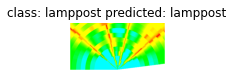

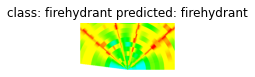

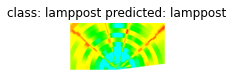

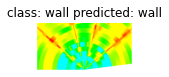

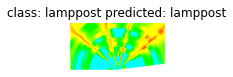

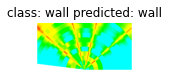

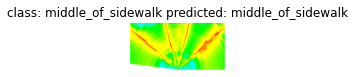

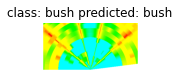

In [198]:
class_names = list(class_map.keys())
visualize_model(model, class_names, 8)